Нужно построить 7-, 14-, 30-, 60-дневные когорты публикаций блогеров по месяцам регистраций блогеров.
Задача понять, сколько блогеров в разрезе blogger_id публикуется в первые 7, 14, 30, 60 дней на СРА(Cost Per Action) проектах.

In [183]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [184]:
df_post = pd.read_csv('posts_test.csv', parse_dates = ['published_at'])
df_post.head()

,Unnamed: 0,id,project_id,blogger_id,type,type.1,status,published_at,network,blogger_subscribers
0,1,439641,351,80960,stories,cpa,published,2020-12-13 10:00:00,instagram,18285.0
1,2,187033,46,142138,stories,cpa,published,2020-08-10 21:00:00,instagram,15050.0
2,3,223710,282,80960,stories,cpa,published,2020-09-09 11:00:00,instagram,18285.0
3,6,367410,128,164818,stories,cpa,published,2020-11-18 13:00:00,instagram,158988.0
4,8,367791,113,244340,stories,cpa,published,2020-11-18 14:00:00,instagram,8684.0


In [185]:
df_users = pd.read_csv('users_test.csv', parse_dates = ['created_at'])
df_users.head()

,Unnamed: 0,user_id,blogger_id,role,created_at
0,182,183,2019,blogger,2019-05-21 11:08:17
1,183,184,11985,blogger,2019-05-21 13:31:29
2,184,185,20985,blogger,2019-05-21 14:08:35
3,185,186,20964,blogger,2019-05-21 14:28:06
4,186,187,22033,blogger,2019-05-21 14:33:11


In [186]:
df_post.nunique()

Unnamed: 0             391917
id                     391917
project_id                401
blogger_id              37398
type                        6
type.1                      3
status                      1
published_at            46476
network                     9
blogger_subscribers     21147
dtype: int64

In [187]:
df_post.isna().sum()

Unnamed: 0             0
id                     0
project_id             0
blogger_id             0
type                   0
type.1                 0
status                 0
published_at           0
network                0
blogger_subscribers    1
dtype: int64

In [188]:
df_post.drop(columns=['Unnamed: 0'], inplace=True)
df_post.rename(columns={"type.1": "type_1"}, inplace=True)

In [189]:
df_users.nunique() # Тут видим, что количество уникальных user_id превышает blogger_id (?)

Unnamed: 0    124664
user_id       124664
blogger_id    124165
role               1
created_at    124297
dtype: int64

In [190]:
df_users.isna().sum() # Здесь ответ на вопрос выше: "Куда делись blogger_id?" Их нет.

Unnamed: 0      0
user_id         0
blogger_id    499
role            0
created_at      0
dtype: int64

In [191]:
df_users = df_users.dropna() # Удаляем ненужную колонку и строчки с пустыми blogger_id
df_users.drop(columns=['Unnamed: 0'], inplace=True)

In [192]:
# Также можно заметить, что под одним user_id иногда зарегистрированы по несколько blogger_id, объединенных в одной строке.
# Преобразовываем эти строки в список, затем каждый элемент списка в отдельный ряд, при этом сами индексы строк дублируются.
df_users.blogger_id = df_users.blogger_id.apply(lambda x: x.split(',')) 
df_users = df_users.explode('blogger_id')

In [193]:
df_users.nunique() # Проверяем количество уникальных blogger_id

user_id       124165
blogger_id    135006
role               1
created_at    123800
dtype: int64

In [194]:
df_users.dtypes

user_id                int64
blogger_id            object
role                  object
created_at    datetime64[ns]
dtype: object

In [195]:
df_post.dtypes

id                              int64
project_id                      int64
blogger_id                      int64
type                           object
type_1                         object
status                         object
published_at           datetime64[ns]
network                        object
blogger_subscribers           float64
dtype: object

In [196]:
# Объединяем два датафрейма по колонке blogger_id, для этого переводим их в одинаковый тип 'int'
df_users.blogger_id = df_users.blogger_id.astype('int')
df_merge = df_post.merge(df_users, how='inner', on='blogger_id')

In [197]:
# Создаем новую колонку, где считаем время от момента регистрации до публикации. 
df_merge['days_since_published_at'] = df_merge.published_at - df_merge.created_at
df_merge.days_since_published_at = df_merge.days_since_published_at.dt.days

In [198]:
df_merge.head()

,id,project_id,blogger_id,type,type_1,status,published_at,network,blogger_subscribers,user_id,role,created_at,days_since_published_at
0,439641,351,80960,stories,cpa,published,2020-12-13 10:00:00,instagram,18285.0,11014,blogger,2019-11-20 13:00:29,388
1,223710,282,80960,stories,cpa,published,2020-09-09 11:00:00,instagram,18285.0,11014,blogger,2019-11-20 13:00:29,293
2,273572,282,80960,stories,cpa,published,2020-10-13 11:00:00,instagram,18285.0,11014,blogger,2019-11-20 13:00:29,327
3,304789,282,80960,stories,cpa,published,2020-10-27 15:00:00,instagram,18285.0,11014,blogger,2019-11-20 13:00:29,342
4,302189,282,80960,stories,cpa,published,2020-10-26 16:00:00,instagram,18285.0,11014,blogger,2019-11-20 13:00:29,341


In [199]:
# Месяц и год регистрации выделяем в отдельную колонку.
df_merge['month_created_at'] = df_merge.created_at.apply(lambda x: x.strftime("%Y-%m"))
df_merge.head()

,id,project_id,blogger_id,type,type_1,status,published_at,network,blogger_subscribers,user_id,role,created_at,days_since_published_at,month_created_at
0,439641,351,80960,stories,cpa,published,2020-12-13 10:00:00,instagram,18285.0,11014,blogger,2019-11-20 13:00:29,388,2019-11
1,223710,282,80960,stories,cpa,published,2020-09-09 11:00:00,instagram,18285.0,11014,blogger,2019-11-20 13:00:29,293,2019-11
2,273572,282,80960,stories,cpa,published,2020-10-13 11:00:00,instagram,18285.0,11014,blogger,2019-11-20 13:00:29,327,2019-11
3,304789,282,80960,stories,cpa,published,2020-10-27 15:00:00,instagram,18285.0,11014,blogger,2019-11-20 13:00:29,342,2019-11
4,302189,282,80960,stories,cpa,published,2020-10-26 16:00:00,instagram,18285.0,11014,blogger,2019-11-20 13:00:29,341,2019-11


In [201]:
# Создаем категории публикаций блогеров в первые 7, 14, 30, 60 дней с момента регистрации.
# Данные, не вошедшие в эти категории далее в расчет брать не будем, в колонке 'categorial' они будут обозначаться как NaN.
bins = pd.IntervalIndex.from_tuples([(-1, 7), (7, 14), (14, 30), (30, 60)])
x = pd.cut(df_merge.days_since_published_at.to_list(), bins)
x.categories = ['0-7 days', '7-14 days', '14-30 days', '30-60 days']
df_merge['categorial'] = x
df_merge.head()

,id,project_id,blogger_id,type,type_1,status,published_at,network,blogger_subscribers,user_id,role,created_at,days_since_published_at,month_created_at,categorial
0,439641,351,80960,stories,cpa,published,2020-12-13 10:00:00,instagram,18285.0,11014,blogger,2019-11-20 13:00:29,388,2019-11,NaN
1,223710,282,80960,stories,cpa,published,2020-09-09 11:00:00,instagram,18285.0,11014,blogger,2019-11-20 13:00:29,293,2019-11,NaN
2,273572,282,80960,stories,cpa,published,2020-10-13 11:00:00,instagram,18285.0,11014,blogger,2019-11-20 13:00:29,327,2019-11,NaN
3,304789,282,80960,stories,cpa,published,2020-10-27 15:00:00,instagram,18285.0,11014,blogger,2019-11-20 13:00:29,342,2019-11,NaN
4,302189,282,80960,stories,cpa,published,2020-10-26 16:00:00,instagram,18285.0,11014,blogger,2019-11-20 13:00:29,341,2019-11,NaN


In [202]:
# Из предыдущего датафрейма отбираем только публикации в первые 60 дней и по СРА.
df_cpa = df_merge.query('type_1 == "cpa" and categorial in ["0-7 days", "7-14 days", "14-30 days", "30-60 days"]')
df_cpa.head()

,id,project_id,blogger_id,type,type_1,status,published_at,network,blogger_subscribers,user_id,role,created_at,days_since_published_at,month_created_at,categorial
327,51413,176,80960,stories,cpa,published,2020-01-15 14:00:00,instagram,18285.0,11014,blogger,2019-11-20 13:00:29,56,2019-11,30-60 days
343,52218,176,80960,stories,cpa,published,2020-01-15 13:00:00,instagram,18285.0,11014,blogger,2019-11-20 13:00:29,55,2019-11,30-60 days
527,49093,60,80960,stories,cpa,published,2020-01-03 08:00:00,instagram,18285.0,11014,blogger,2019-11-20 13:00:29,43,2019-11,30-60 days
617,52256,60,80960,stories,cpa,published,2020-01-14 00:00:00,instagram,18285.0,11014,blogger,2019-11-20 13:00:29,54,2019-11,30-60 days
2697,79578,262,164818,stories,cpa,published,2020-04-02 14:00:00,instagram,158988.0,17520,blogger,2020-02-03 19:16:04,58,2020-02,30-60 days


In [203]:
df_blog = df_cpa.groupby(['categorial', 'month_created_at']).blogger_id.nunique().to_frame().reset_index()
df_blog.head()

,categorial,month_created_at,blogger_id
0,0-7 days,2019-11,0
1,0-7 days,2019-12,12
2,0-7 days,2020-01,575
3,0-7 days,2020-02,810
4,0-7 days,2020-03,1050


In [205]:
df_blog.dtypes

categorial          category
month_created_at      object
blogger_id             int64
dtype: object

In [206]:
df_blog = df_blog.pivot( columns='month_created_at', index='categorial', values='blogger_id')
df_blog

month_created_at,2019-11,2019-12,2020-01,2020-02,2020-03,2020-04,2020-05,2020-06,2020-07,2020-08,2020-09,2020-10,2020-11,2020-12
categorial,,,,,,,,,,,,,,
0-7 days,0,12,575,810,1050,865,1437,1287,1454,1480,1346,1803,2027,1593
7-14 days,0,58,154,342,387,263,525,482,558,527,406,841,825,440
14-30 days,0,224,212,429,423,414,758,602,682,630,646,1045,1020,273
30-60 days,150,348,284,450,493,382,757,633,630,635,757,1090,679,0


<AxesSubplot:xlabel='month_created_at', ylabel='categorial'>

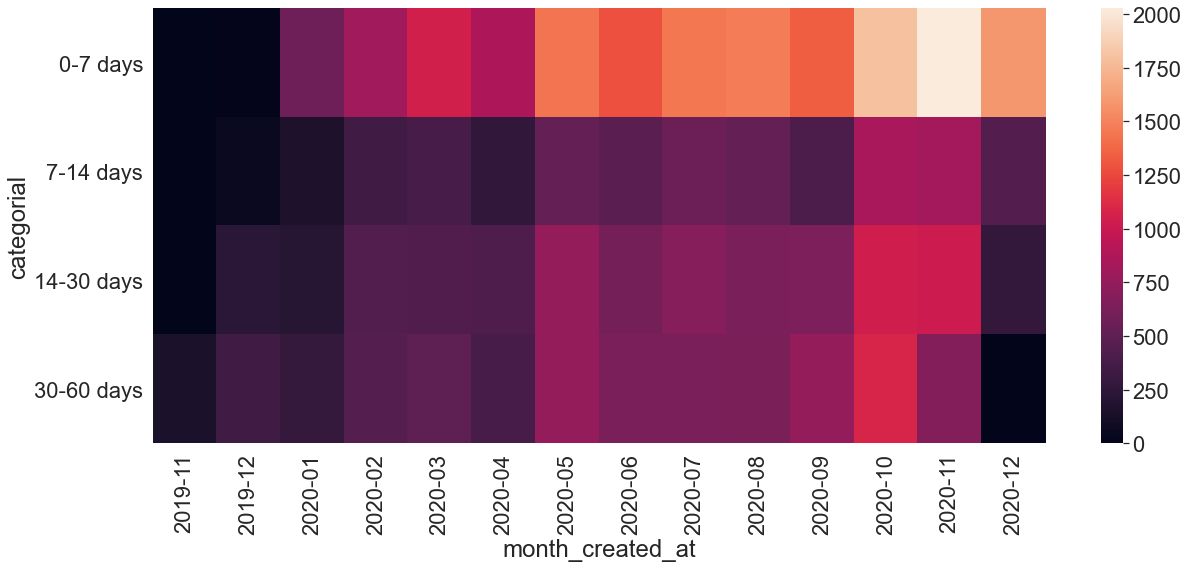

In [214]:
sns.heatmap(data = df_blog)

Таким образом, наибольшее количество публикаций от уникальных блогеров наблюдается в первые 7 дней после регистрации на платформе. Также пик публикаций приходится на блогеров, зарегистрировавшихся в ноябре и октябре на платформе.